<a href="https://colab.research.google.com/github/sanjana-vivek/Longitudinal-voice-deterioration-in-Parkinson-s-patients-/blob/main/Novel_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# upgrade basics
!pip install --upgrade pip setuptools wheel

# Core audio + processing
!pip install librosa soundfile matplotlib pandas tqdm scipy scikit-learn

# Praat bindings
!pip install praat-parselmouth

# Nonlinear & recurrence
!pip install nolds

# Wavelet libraries
!pip install PyWavelets

# Wavelet scattering
!pip install kymatio

# Transformers & torch
!pip install transformers torch

# Optional: openSMILE wrapper
# !pip install opensmile


In [4]:

import os
import glob
import math
import json
from datetime import datetime
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import soundfile as sf
import pywt
import nolds
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import resample, medfilt
from scipy.stats import skew, kurtosis


#imports that might be heavy/fail - wrapping in try/except for graceful fallback
try:
    import parselmouth  # praat bindings
    from parselmouth.praat import call as praat_call
    PRAAT_AVAILABLE = True
except Exception as e:
    print("parselmouth not available:", e)
    PRAAT_AVAILABLE = False

try:
    import kymatio
    from kymatio import Scattering1D
    KYMATIO_AVAILABLE = True
except Exception as e:
    print("kymatio not available:", e)
    KYMATIO_AVAILABLE = False

try:
    import torch
    from transformers import Wav2Vec2Processor, Wav2Vec2Model
    TRANSFORMERS_AVAILABLE = True
except Exception as e:
    print("transformers/torch import failed:", e)
    TRANSFORMERS_AVAILABLE = False

print("PRAAT_AVAILABLE:", PRAAT_AVAILABLE, "KYMATIO_AVAILABLE:", KYMATIO_AVAILABLE, "TRANSFORMERS_AVAILABLE:", TRANSFORMERS_AVAILABLE)


/usr/local/lib/python3.12/dist-packages/nolds/datasets.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


PRAAT_AVAILABLE: True KYMATIO_AVAILABLE: True TRANSFORMERS_AVAILABLE: True


In [5]:
# Torch / GPU environment check
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("Running on CPU only")


Torch version: 2.8.0+cu126
CUDA available: False
Running on CPU only


In [6]:
# Mounting Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import glob, os


BASE_PATH = "/content/drive/My Drive/pd_data/denoised-speech-dataset"

# Look recursively for wav files (case-insensitive)
wav_files = glob.glob(os.path.join(BASE_PATH, "**", "*.wav"), recursive=True)
wav_files += glob.glob(os.path.join(BASE_PATH, "**", "*.WAV"), recursive=True)

print(f"Total audio files found: {len(wav_files)}")
print("Sample files:", wav_files[:5])


# import os
# subfolder = os.path.join(BASE_PATH, "emma")
# print("Files in emma:", os.listdir(subfolder)[:10])



Total audio files found: 578
Sample files: ['/content/drive/My Drive/pd_data/denoised-speech-dataset/LW/LW20.wav', '/content/drive/My Drive/pd_data/denoised-speech-dataset/LW/LW13.wav', '/content/drive/My Drive/pd_data/denoised-speech-dataset/LW/LW10.wav', '/content/drive/My Drive/pd_data/denoised-speech-dataset/LW/LW15.wav', '/content/drive/My Drive/pd_data/denoised-speech-dataset/LW/LW1.wav']


In [8]:
pip install pyroomacoustics

In [9]:
# Basic audio helpers and file discovery according to your structure
BASE_DIR = "/content/drive/MyDrive/pd_data/denoised-speech-dataset"

TARGET_SR = 16000  # wav2vec requirement and standardize

def list_all_wavs(base_dir=BASE_DIR):
    pattern = os.path.join(base_dir, "**", "*.wav")
    files = sorted(glob.glob(pattern, recursive=True))
    return files

def load_resample(path, sr=TARGET_SR):
    # read with soundfile to preserve bit depth, then resample if needed
    y, orig_sr = sf.read(path, always_2d=False)
    if y.ndim > 1:
        y = np.mean(y, axis=1)  # to mono
    if orig_sr != sr:
        y = librosa.resample(y.astype(np.float32), orig_sr, sr)
    return y.astype(np.float32), sr

def vad_trim(y, sr=TARGET_SR, top_db=25):
    # simple energy-based trim using librosa
    intervals = librosa.effects.split(y, top_db=top_db)
    if len(intervals) == 0:
        return y  # nothing to trim
    trimmed = np.concatenate([y[s:e] for s,e in intervals])
    return trimmed

# Discover files for sanity check
all_wavs = list_all_wavs()
print(f"Found {len(all_wavs)} .wav files under {BASE_DIR}. Example (first 10):")
for p in all_wavs[:10]:
    print(" ", p)
print("Cell 4 finished: helper functions ready and dataset scanned.")


Found 578 .wav files under /content/drive/MyDrive/pd_data/denoised-speech-dataset. Example (first 10):
  /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL1.wav
  /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL10.wav
  /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL16.wav
  /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL17.wav
  /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL18.wav
  /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL19.wav
  /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL2.wav
  /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL21.wav
  /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL22.wav
  /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL23.wav
Cell 4 finished: helper functions ready and dataset scanned.


In [10]:
# SPL frame RMS -> dB computations and session stats
def framewise_rms_db(y, sr=TARGET_SR, frame_ms=25, hop_ms=10, amin=1e-9):
    frame_len = int(sr * frame_ms / 1000)
    hop_len = int(sr * hop_ms / 1000)
    if len(y) < frame_len:
        # pad short signals
        pad = frame_len - len(y)
        y = np.pad(y, (0, pad))
    frames = librosa.util.frame(y, frame_length=frame_len, hop_length=hop_len).astype(np.float32)
    rms = np.sqrt(np.mean(frames**2, axis=0) + amin)
    db = 20 * np.log10(rms + amin)  # relative dB (not calibrated SPL)
    return db

def session_spl_stats(y, sr=TARGET_SR):
    db = framewise_rms_db(y, sr)
    stats = {
        "spl_mean_db": float(np.mean(db)),
        "spl_peak_db": float(np.max(db)),
        "spl_std_db": float(np.std(db)),
        "spl_frames": int(len(db))
    }
    print(f"[SPL] mean={stats['spl_mean_db']:.2f} dB, peak={stats['spl_peak_db']:.2f} dB, frames={stats['spl_frames']}")
    return stats

# Demo on a sample file (if present)
if len(all_wavs) > 0:
    path = all_wavs[0]
    y, sr = load_resample(path)
    y_trim = vad_trim(y, sr)
    print("File used for demo:", path)
    spl_demo_raw = session_spl_stats(y, sr)
    spl_demo_trim = session_spl_stats(y_trim, sr)
else:
    print("No wav files found to demo SPL calculations.")
print("SPL calculation functions available (printed demo stats).")


File used for demo: /content/drive/MyDrive/pd_data/denoised-speech-dataset/DL/DL1.wav
[SPL] mean=-53.47 dB, peak=-22.08 dB, frames=898
[SPL] mean=-36.69 dB, peak=-21.60 dB, frames=523
SPL calculation functions available (printed demo stats).


### **Typical healthy adult male/female ranges vs Parkinson’s-affected ranges for the features extracting**

----------------------------------------------------------------




| Feature             | Typical Healthy Range         | Parkinson’s Indicative Range                         | Notes                                                       |
| ------------------- | ----------------------------- | ---------------------------------------------------- | ----------------------------------------------------------- |
| **F0 median (Hz)**  | Male: 85–180, Female: 165–255 | Often normal, can be slightly lower or more variable | Alone, not diagnostic                                       |
| **F0 std (Hz)**     | 10–30                         | Often elevated (>40 Hz)                              | High variability may indicate instability in voice          |
| **HNR mean (dB)**   | 15–20+                        | 5–12                                                 | Lower HNR = more noise; common in hypophonia/dysarthria     |
| **Jitter (local)**  | <1–1.5%                       | >2–5%                                                | Cycle-to-cycle frequency variation; elevated in Parkinson’s |
| **Shimmer (local)** | <3–5%                         | >6–10%                                               | Cycle-to-cycle amplitude variation; elevated in Parkinson’s |
| **F1 mean (Hz)**    | \~500–800                     | Slightly altered                                     | Mainly vowel characterization                               |
| **F2 mean (Hz)**    | \~1200–2000                   | Slightly altered                                     | May reflect articulatory imprecision                        |
| **F3 mean (Hz)**    | \~2500–3000                   | Slightly altered                                     | Less sensitive; can show mild resonance changes             |


In [11]:
import os
import numpy as np
import librosa
import pandas as pd

# Optional: Parselmouth
try:
    import parselmouth
    PRAAT_AVAILABLE = True
except ImportError:
    PRAAT_AVAILABLE = False
    print("Parselmouth not available. Using pyin-based fallbacks for jitter/shimmer.")

# ------------------------------
# Helpers
# ------------------------------
def load_resample(path, target_sr=16000):
    y, sr = librosa.load(path, sr=None)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    return y, sr

def vad_trim(y, sr):
    y_trim, _ = librosa.effects.trim(y, top_db=30)
    return y_trim

# ------------------------------
# Classical feature extraction
# ------------------------------
def classical_features(path):
    y, sr = load_resample(path)
    y_trim = vad_trim(y, sr)
    feats = {"filename": os.path.basename(path)}

    # ---------- F0, HNR, Formants ----------
    if PRAAT_AVAILABLE:
        try:
            snd = parselmouth.Sound(y_trim, sr)

            # --- Pitch
            pitch = snd.to_pitch()
            f0_vals = pitch.selected_array['frequency']
            f0_vals = f0_vals[f0_vals > 0]
            feats['f0_median'] = float(np.median(f0_vals)) if len(f0_vals) > 0 else np.nan
            feats['f0_std'] = float(np.std(f0_vals)) if len(f0_vals) > 0 else np.nan

            # --- HNR
            try:
                ham = parselmouth.praat.call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
                feats['hnr_mean'] = float(parselmouth.praat.call(ham, "Get mean", 0, 0))
            except:
                feats['hnr_mean'] = np.nan

            # --- Formants
            try:
                form = snd.to_formant_burg()
                def form_mean(idx):
                    times = np.linspace(0, snd.duration, 50)
                    vals = [parselmouth.praat.call(form, "Get value at time", idx, t, "Hertz", "Linear")
                            for t in times if parselmouth.praat.call(form, "Get value at time", idx, t, "Hertz", "Linear") > 0]
                    return float(np.mean(vals)) if vals else np.nan
                feats['f1_mean'] = form_mean(1)
                feats['f2_mean'] = form_mean(2)
                feats['f3_mean'] = form_mean(3)
            except:
                feats['f1_mean'] = np.nan
                feats['f2_mean'] = np.nan
                feats['f3_mean'] = np.nan

            # --- Jitter & Shimmer (Praat-style, robust)
            try:
                pp = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 500)
                feats['jitter_local'] = float(parselmouth.praat.call(pp, "Get jitter (local)", 0, 0, 75, 500, 1.3))
                feats['shimmer_local'] = float(parselmouth.praat.call([snd, pp], "Get shimmer (local)",
                                                                      0, 0, 75, 500, 1.3, 1.6, 0.03, 1.6))
            except:
                # fallback if Praat fails
                feats['jitter_local'] = np.nan
                feats['shimmer_local'] = np.nan

        except Exception as e:
            print("Parselmouth top-level error:", e)
            feats.update({'f0_median': np.nan, 'f0_std': np.nan, 'hnr_mean': np.nan,
                          'f1_mean': np.nan, 'f2_mean': np.nan, 'f3_mean': np.nan,
                          'jitter_local': np.nan, 'shimmer_local': np.nan})
    else:
        # Fallback: librosa pyin for F0 only
        try:
            f0, _, _ = librosa.pyin(y_trim, fmin=50, fmax=500, sr=sr)
            f0_vals = f0[~np.isnan(f0)]
            feats['f0_median'] = float(np.median(f0_vals)) if len(f0_vals) > 0 else np.nan
            feats['f0_std'] = float(np.std(f0_vals)) if len(f0_vals) > 0 else np.nan
        except:
            feats['f0_median'] = np.nan
            feats['f0_std'] = np.nan
        feats.update({'hnr_mean': np.nan, 'f1_mean': np.nan,
                      'f2_mean': np.nan, 'f3_mean': np.nan,
                      'jitter_local': np.nan, 'shimmer_local': np.nan})

    # ---------- Approx jitter/shimmer fallback if NaN ----------
    if np.isnan(feats.get('jitter_local')) or np.isnan(feats.get('shimmer_local')):
        try:
            f0_voiced = f0_vals
            if len(f0_voiced) >= 3:
                periods = 1.0 / f0_voiced
                feats['jitter_local'] = float(np.mean(np.abs(np.diff(periods))) / np.mean(periods))

                frame_length = 2048
                hop_length = 256
                rms_frames = librosa.feature.rms(y=y_trim, frame_length=frame_length, hop_length=hop_length)[0]
                L = min(len(rms_frames), len(f0_voiced))
                rms_voiced = rms_frames[:L]
                feats['shimmer_local'] = float(np.mean(np.abs(np.diff(rms_voiced))) / np.mean(rms_voiced))
            else:
                feats['jitter_local'] = 0.0
                feats['shimmer_local'] = 0.0
        except:
            feats['jitter_local'] = 0.0
            feats['shimmer_local'] = 0.0

    return pd.DataFrame([feats])

# ------------------------------
# Demo
# ------------------------------
if len(all_wavs) > 0:
    sample_file = all_wavs[0]
    df = classical_features(sample_file)
    print("\n--- FINAL FEATURE SUMMARY(for 1st .wav recording demo) ---")
    print(df.to_string(index=False))
    print("--- end summary ---\n")
else:
    print("No WAV files found.")



--- FINAL FEATURE SUMMARY(for 1st .wav recording demo) ---
filename  f0_median     f0_std  hnr_mean    f1_mean     f2_mean     f3_mean  jitter_local  shimmer_local
 DL1.wav 120.785096 102.357192  5.191033 720.909728 1868.593583 2964.681521      0.030719       0.080309
--- end summary ---



In [12]:
# Non-linear and complexity features
import numpy as np
import librosa
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
import os

TARGET_SR_NL = 1000  # downsample rate for nonlinear features

# ------------------------------
# Helpers
# ------------------------------
def load_resample(path, target_sr=16000):
    y, sr = librosa.load(path, sr=None)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    return y, sr

def vad_trim(y, sr):
    y_trim, _ = librosa.effects.trim(y, top_db=30)
    return y_trim

def safe_downsample(y, orig_sr, target_sr=TARGET_SR_NL):
    if orig_sr != target_sr:
        y = librosa.resample(y, orig_sr=orig_sr, target_sr=target_sr)
    return y, target_sr

# ------------------------------
# Nonlinear feature functions
# ------------------------------
def spectral_entropy(y, sr=TARGET_SR_NL, n_fft=256, hop_length=64):
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2
    ps = S / (np.sum(S, axis=0, keepdims=True) + 1e-12)
    ent = np.mean([entropy(col + 1e-12) for col in ps.T])
    return float(ent)

def permutation_entropy(y, order=3, delay=1, max_len=5000):
    x = y.copy()
    if len(x) > max_len:
        x = x[:max_len]
    n = len(x)
    patterns = {}
    for i in range(n - (order-1)*delay):
        window = x[i:i+order*delay:delay]
        ranks = tuple(np.argsort(window))
        patterns[ranks] = patterns.get(ranks, 0) + 1
    ps = np.array(list(patterns.values()), dtype=float)
    ps /= ps.sum() + 1e-12
    return float(-np.sum(ps * np.log2(ps + 1e-12)))

def recurrence_rate(y, emb_dim=3, tau=1, eps_factor=0.1, max_samples=2000):
    N = len(y)
    M = N - (emb_dim-1)*tau
    if M <= 0:
        return np.nan
    X = np.zeros((M, emb_dim))
    for i in range(M):
        for j in range(emb_dim):
            X[i,j] = y[i + j*tau]
    X = (X - X.mean(axis=0)) / (X.std(axis=0)+1e-9)
    # subsample if too large
    if M > max_samples:
        idx = np.linspace(0, M-1, max_samples).astype(int)
        X = X[idx]
        M = max_samples
    eps = eps_factor * np.median(np.linalg.norm(X, axis=1))
    nbrs = NearestNeighbors(radius=eps)
    nbrs.fit(X)
    rr = np.mean([len(nbrs.radius_neighbors([X[i]], return_distance=False)[0])/M for i in range(M)])
    return float(rr)

def rpde_approx(y, sr=TARGET_SR_NL):
    y = (y - np.mean(y)) / (np.std(y)+1e-9)
    win = int(0.5 * sr)
    step = int(0.25 * sr)
    errs = []
    for s in range(0, max(1,len(y)-win), step):
        seg = y[s:s+win]
        if len(seg) < 50:
            continue
        order = 4
        if len(seg) < order + 1:
            continue
        X = np.vstack([seg[i: i+len(seg)-order] for i in range(order)]).T
        ytarget = seg[order:]
        try:
            lr = LinearRegression().fit(X, ytarget)
            pred = lr.predict(X)
            errs.append(np.mean((pred-ytarget)**2))
        except:
            continue
    return float(np.mean(errs)) if errs else np.nan

# ------------------------------
# Nonlinear features wrapper
# ------------------------------
def nonlinear_features(path):
    y, sr = load_resample(path)
    y_trim = vad_trim(y, sr)
    y_ds, sr_ds = safe_downsample(y_trim, sr)

    feats = {
        "spectral_entropy": spectral_entropy(y_ds, sr_ds),
        "perm_entropy": permutation_entropy(y_ds),
        "recurrence_rate": recurrence_rate(y_ds),
        "rpde_approx": rpde_approx(y_ds, sr_ds)
    }
    print(f"[NonLinear] {os.path.basename(path)} -> spectral_entropy={feats['spectral_entropy']:.3f}, perm_entropy={feats['perm_entropy']:.3f}, recurrence_rate={feats['recurrence_rate']:.3f}, rpde={feats['rpde_approx']:.3f}")
    return feats

# ------------------------------
# Demo
# ------------------------------
if len(all_wavs) > 0:
    feats_nl = nonlinear_features(all_wavs[0])
    print(feats_nl)
else:
    print("No WAV files for non-linear demo.")



[NonLinear] DL1.wav -> spectral_entropy=2.766, perm_entropy=2.558, recurrence_rate=0.006, rpde=0.584
{'spectral_entropy': 2.765854835510254, 'perm_entropy': 2.557897860862821, 'recurrence_rate': 0.005557500000000001, 'rpde_approx': 0.5840844511985779}


In [13]:
# Wavelet band energies (pywt) and scattering (kymatio)
def wavelet_band_energy(y, wavelet='db4', levels=5):
    coeffs = pywt.wavedec(y, wavelet, level=levels)
    energies = [float(np.sum(c**2)) for c in coeffs]
    total = sum(energies) + 1e-12
    ratios = [e/total for e in energies]
    feats = {f"wavelet_energy_{i}": energies[i] for i in range(len(energies))}
    feats.update({f"wavelet_ratio_{i}": ratios[i] for i in range(len(ratios))})
    print(f"[Wavelet] computed {len(energies)} band energies")
    return feats

def wavelet_scattering_feats(y):
    if not KYMATIO_AVAILABLE:
        print("kymatio not available: skipping scattering features.")
        return {}

    # Kymatio requires length = power of 2 for stability
    N = len(y)
    L = 1 << (N-1).bit_length()  # next power of 2
    y_pad = np.zeros(L, dtype=np.float32)
    y_pad[:N] = y

    scattering = Scattering1D(J=6, shape=L, Q=8)  # default backend (PyTorch)

    import torch
    x_torch = torch.from_numpy(y_pad).float().unsqueeze(0)  # shape (1, L)
    Sx = scattering(x_torch)

    # convert tensor to numpy safely
    if isinstance(Sx, torch.Tensor):
        Sx_np = Sx.squeeze(0).detach().cpu().numpy()
    else:
        Sx_np = Sx.squeeze(0)  # already numpy

    feats = {}
    # pool mean/std across time dimension
    if Sx_np.ndim == 2:
        for i in range(Sx_np.shape[0]):
            feats[f"scat_mean_{i}"] = float(Sx_np[i].mean())
            feats[f"scat_std_{i}"] = float(Sx_np[i].std())

    print(f"[Scattering] produced {len(feats)//2} coefficients (mean+std)")
    return feats

# Demo
if len(all_wavs)>0:
    y, sr = load_resample(all_wavs[0])
    print(wavelet_band_energy(y))
    print(wavelet_scattering_feats(y))
else:
    print("No files for wavelet demo.")
print("Processing finished: wavelet features ready (scattering optional).")


[Wavelet] computed 6 band energies
{'wavelet_energy_0': 14.426042556762695, 'wavelet_energy_1': 20.235370635986328, 'wavelet_energy_2': 18.979015350341797, 'wavelet_energy_3': 5.873523712158203, 'wavelet_energy_4': 2.5607287883758545, 'wavelet_energy_5': 2.3814194202423096, 'wavelet_ratio_0': 0.22381190380652063, 'wavelet_ratio_1': 0.3139403483977372, 'wavelet_ratio_2': 0.29444870561136044, 'wavelet_ratio_3': 0.0911244035845869, 'wavelet_ratio_4': 0.03972826109471684, 'wavelet_ratio_5': 0.03694637750506252}
[Scattering] produced 126 coefficients (mean+std)
{'scat_mean_0': 1.5620025798070242e-06, 'scat_std_0': 0.00024735379371832274, 'scat_mean_1': 0.00015248437625156705, 'scat_std_1': 0.0006483833167553648, 'scat_mean_2': 0.0001616193684389063, 'scat_std_2': 0.0006721090537946241, 'scat_mean_3': 0.00014197799411565614, 'scat_std_3': 0.00047335073981916723, 'scat_mean_4': 0.00013372710759959017, 'scat_std_4': 0.00039183923449974124, 'scat_mean_5': 0.00015446997817242608, 'scat_std_5': 0

In [14]:
# wav2vec embeddings summary + baseline-drift
# Note: this uses HuggingFace Wav2Vec2 via transformers. Ensure transformers and torch are installed.

if TRANSFORMERS_AVAILABLE:
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
    model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
    model.eval()
else:
    processor = None
    model = None

def extract_wav2vec_stats(y, sr=TARGET_SR):
    if not TRANSFORMERS_AVAILABLE:
        print("transformers not available: skipping embedding extraction.")
        return {}
    # processor expects numpy array, sampling rate TARGET_SR
    import torch
    input_values = processor(y, sampling_rate=sr, return_tensors="pt", padding=True).input_values
    with torch.no_grad():
        outputs = model(input_values)
    emb = outputs.last_hidden_state.squeeze(0).cpu().numpy()  # frames x dim
    stats = {
        "emb_mean_mean": float(np.mean(emb.mean(axis=0))),
        "emb_mean_std": float(np.std(emb.mean(axis=0))),
        "emb_flat_skew": float(skew(emb.flatten())),
        "emb_flat_kurtosis": float(kurtosis(emb.flatten())),
        "emb_frames": int(emb.shape[0])
    }
    print(f"[Embeddings] frames={stats['emb_frames']}, mean_mean={stats['emb_mean_mean']:.4f}")
    return stats

def embedding_baseline_drift(y_emb, baseline_emb):
    # y_emb, baseline_emb are arrays frames x dim (or mean vectors)
    if y_emb is None or baseline_emb is None:
        return {"embedding_drift": np.nan}
    # reduce to mean vectors if frames x dim
    y_mean = np.mean(y_emb, axis=0) if y_emb.ndim==2 else y_emb
    b_mean = np.mean(baseline_emb, axis=0) if baseline_emb.ndim==2 else baseline_emb
    # cosine distance
    cos_sim = 1 - cdist([y_mean], [b_mean], metric='cosine')[0,0]
    drift = float(1 - cos_sim)  # distance measure
    return {"embedding_drift": drift}

# Demo
if len(all_wavs)>0 and TRANSFORMERS_AVAILABLE:
    y, sr = load_resample(all_wavs[0])
    emb_stats = extract_wav2vec_stats(y, sr)
    print(emb_stats)
else:
    print("No embedding demo (either no files or transformers not available).")
print("Processing finished: embedding feature functions ready (baseline-drift function included).")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Embeddings] frames=449, mean_mean=0.0013
{'emb_mean_mean': 0.0012542431941255927, 'emb_mean_std': 0.2277728170156479, 'emb_flat_skew': 0.294329971075058, 'emb_flat_kurtosis': 12.637311935424805, 'emb_frames': 449}
Processing finished: embedding feature functions ready (baseline-drift function included).


Found 20 wav files for analysis under /content/drive/MyDrive/pd_data/denoised-speech-dataset/LW


  0%|          | 0/20 [00:00<?, ?it/s]

[SPL] mean=-36.19 dB, peak=-21.14 dB, frames=548
[NonLinear] LW1.wav -> spectral_entropy=2.806, perm_entropy=2.568, recurrence_rate=0.004, rpde=0.363
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=274, mean_mean=-0.0009


  5%|▌         | 1/20 [00:08<02:32,  8.03s/it]

[SPL] mean=-37.63 dB, peak=-23.77 dB, frames=302
[NonLinear] LW10.wav -> spectral_entropy=2.432, perm_entropy=2.508, recurrence_rate=0.010, rpde=0.253
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=151, mean_mean=-0.0007


 10%|█         | 2/20 [00:12<01:50,  6.12s/it]

[SPL] mean=-41.15 dB, peak=-23.01 dB, frames=219
[NonLinear] LW11.wav -> spectral_entropy=3.126, perm_entropy=2.544, recurrence_rate=0.002, rpde=0.575
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=110, mean_mean=-0.0004


 15%|█▌        | 3/20 [00:19<01:46,  6.26s/it]

[SPL] mean=-41.03 dB, peak=-26.72 dB, frames=257
[NonLinear] LW12.wav -> spectral_entropy=2.800, perm_entropy=2.569, recurrence_rate=0.004, rpde=0.397
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=129, mean_mean=0.0001


 20%|██        | 4/20 [00:24<01:35,  5.98s/it]

[SPL] mean=-42.68 dB, peak=-24.91 dB, frames=347
[NonLinear] LW13.wav -> spectral_entropy=2.982, perm_entropy=2.564, recurrence_rate=0.002, rpde=0.416
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=174, mean_mean=-0.0006


 25%|██▌       | 5/20 [00:28<01:17,  5.14s/it]

[SPL] mean=-38.49 dB, peak=-23.78 dB, frames=280
[NonLinear] LW14.wav -> spectral_entropy=3.034, perm_entropy=2.581, recurrence_rate=0.003, rpde=0.389
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=140, mean_mean=0.0003


 30%|███       | 6/20 [00:32<01:07,  4.79s/it]

[SPL] mean=-39.64 dB, peak=-26.44 dB, frames=216
[NonLinear] LW15.wav -> spectral_entropy=2.678, perm_entropy=2.581, recurrence_rate=0.008, rpde=0.417
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=108, mean_mean=-0.0000


 35%|███▌      | 7/20 [00:35<00:53,  4.13s/it]

[SPL] mean=-37.67 dB, peak=-20.90 dB, frames=392
[NonLinear] LW16.wav -> spectral_entropy=2.731, perm_entropy=2.541, recurrence_rate=0.002, rpde=0.407
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=196, mean_mean=-0.0005


 40%|████      | 8/20 [00:38<00:46,  3.92s/it]

[SPL] mean=-38.90 dB, peak=-22.86 dB, frames=155
[NonLinear] LW17.wav -> spectral_entropy=2.975, perm_entropy=2.547, recurrence_rate=0.002, rpde=0.637
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=78, mean_mean=0.0017


 45%|████▌     | 9/20 [00:40<00:36,  3.34s/it]

[SPL] mean=-42.23 dB, peak=-21.88 dB, frames=545
[NonLinear] LW18.wav -> spectral_entropy=2.815, perm_entropy=2.559, recurrence_rate=0.003, rpde=0.351
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=273, mean_mean=0.0009


 50%|█████     | 10/20 [00:46<00:39,  3.93s/it]

[SPL] mean=-40.59 dB, peak=-23.64 dB, frames=376
[NonLinear] LW19.wav -> spectral_entropy=2.753, perm_entropy=2.539, recurrence_rate=0.008, rpde=0.478
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=188, mean_mean=0.0003


 55%|█████▌    | 11/20 [00:49<00:34,  3.83s/it]

[SPL] mean=-43.63 dB, peak=-27.57 dB, frames=244
[NonLinear] LW2.wav -> spectral_entropy=2.770, perm_entropy=2.579, recurrence_rate=0.007, rpde=0.317
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=122, mean_mean=0.0015


 60%|██████    | 12/20 [00:52<00:28,  3.58s/it]

[SPL] mean=-43.80 dB, peak=-25.62 dB, frames=401
[NonLinear] LW20.wav -> spectral_entropy=2.957, perm_entropy=2.571, recurrence_rate=0.003, rpde=0.500
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=201, mean_mean=0.0003


 65%|██████▌   | 13/20 [00:56<00:26,  3.74s/it]

[SPL] mean=-39.76 dB, peak=-25.90 dB, frames=193
[NonLinear] LW21.wav -> spectral_entropy=2.504, perm_entropy=2.574, recurrence_rate=0.026, rpde=0.363
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=97, mean_mean=-0.0008


 70%|███████   | 14/20 [00:59<00:19,  3.32s/it]

[SPL] mean=-43.89 dB, peak=-24.44 dB, frames=475
[NonLinear] LW3.wav -> spectral_entropy=2.664, perm_entropy=2.527, recurrence_rate=0.002, rpde=0.387
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=238, mean_mean=0.0003


 75%|███████▌  | 15/20 [01:03<00:18,  3.71s/it]

[SPL] mean=-45.10 dB, peak=-31.96 dB, frames=289
[NonLinear] LW4.wav -> spectral_entropy=2.484, perm_entropy=2.543, recurrence_rate=0.003, rpde=0.266
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=145, mean_mean=-0.0011


 80%|████████  | 16/20 [01:07<00:14,  3.59s/it]

[SPL] mean=-47.49 dB, peak=-33.72 dB, frames=145
[NonLinear] LW5.wav -> spectral_entropy=2.421, perm_entropy=2.517, recurrence_rate=0.005, rpde=0.249
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=73, mean_mean=-0.0035


 85%|████████▌ | 17/20 [01:09<00:09,  3.16s/it]

[SPL] mean=-43.22 dB, peak=-23.64 dB, frames=401
[NonLinear] LW6.wav -> spectral_entropy=2.741, perm_entropy=2.543, recurrence_rate=0.002, rpde=0.327
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=201, mean_mean=-0.0015


 90%|█████████ | 18/20 [01:12<00:06,  3.20s/it]

[SPL] mean=-39.20 dB, peak=-22.53 dB, frames=232
[NonLinear] LW8.wav -> spectral_entropy=2.772, perm_entropy=2.550, recurrence_rate=0.002, rpde=0.353
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=116, mean_mean=0.0006


 95%|█████████▌| 19/20 [01:15<00:03,  3.13s/it]

[SPL] mean=-37.04 dB, peak=-20.86 dB, frames=184
[NonLinear] LW9.wav -> spectral_entropy=2.851, perm_entropy=2.578, recurrence_rate=0.009, rpde=0.489
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=92, mean_mean=-0.0011


100%|██████████| 20/20 [01:17<00:00,  3.89s/it]
/tmp/ipython-input-1102398301.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yv = df[col].fillna(method='ffill').fillna(0).values.reshape(-1,1)
/tmp/ipython-input-1102398301.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yv = df[col].fillna(method='ffill').fillna(0).values.reshape(-1,1)
/tmp/ipython-input-1102398301.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yv = df[col].fillna(method='ffill').fillna(0).values.reshape(-1,1)
/tmp/ipython-input-1102398301.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yv = df[col].fillna(method='ffill').fillna(0).values.reshape(-1

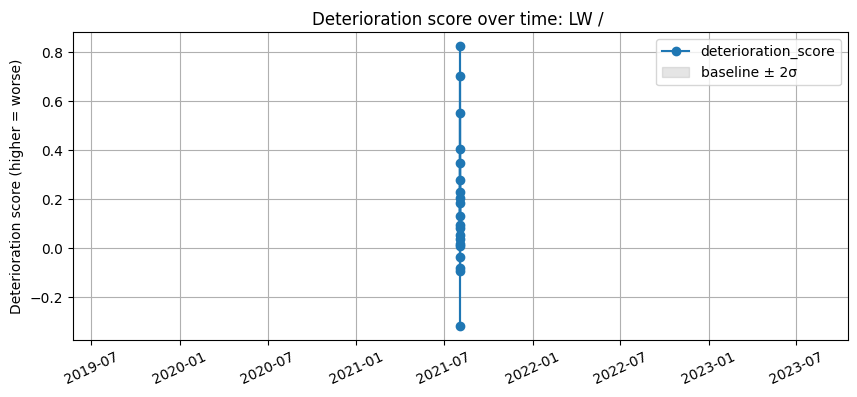

Feature slopes (per day) sample (subset):
{'spl_mean_db': 0.0, 'spl_peak_db': 0.0, 'spl_std_db': 0.0, 'spl_frames': 0.0, 'spectral_entropy': 0.0, 'perm_entropy': 0.0, 'recurrence_rate': 0.0, 'rpde_approx': 0.0, 'wavelet_energy_0': 0.0, 'wavelet_energy_1': 0.0}
CUSUM flags (last 10 sessions): ['pos_alarm', 'pos_alarm', 'pos_alarm', 'pos_alarm', 'pos_alarm', 'pos_alarm', 'pos_alarm', 'pos_alarm', 'pos_alarm', 'pos_alarm']
Processing finished: patient analysis plotted and summary printed.



In [15]:
# Full per-patient pipeline that extracts all features, computes baseline normalization,
# per-feature slope, a simple deterioration_score and CUSUM detection; then plots deterioration line.

import matplotlib.dates as mdates
from datetime import datetime
from tqdm import tqdm

def extract_features_for_file(path):
    """Extract all features for a single WAV file and return dict"""
    feats = {}
    y, sr = load_resample(path)
    y_trim = vad_trim(y, sr)
    # SPL
    feats.update(session_spl_stats(y_trim, sr))
    # Classical
    feats.update(classical_features(path))
    # Nonlinear
    feats.update(nonlinear_features(path))
    # Wavelet
    feats.update(wavelet_band_energy(y_trim))
    # Scattering
    feats.update(wavelet_scattering_feats(y_trim))
    # Embeddings stats
    if TRANSFORMERS_AVAILABLE:
        try:
            emb_stats = extract_wav2vec_stats(y_trim, sr)
            feats.update(emb_stats)
        except Exception as e:
            print("Embedding extraction failed for", path, ":", e)
    # metadata
    feats["_file"] = path
    # session date: try parse from text file next to wav (if exists) else file mtime
    txt_path = os.path.splitext(path)[0] + ".txt"
    if os.path.exists(txt_path):
        try:
            with open(txt_path, 'r', encoding='utf-8') as fh:
                txt = fh.read().strip()
            feats["_transcript"] = txt
            # Optionally parse date from filename if encoded - here we fallback to mtime
        except:
            feats["_transcript"] = ""
    else:
        feats["_transcript"] = ""
    feats["_date"] = datetime.fromtimestamp(os.path.getmtime(path))
    return feats

def analyze_patient(patient_group, patient_subfolder=None):
    """Analyze a single top-level patient group (e.g., 'emma') OR a specific subfolder inside it"""
    if patient_subfolder:
        root_dir = os.path.join(BASE_DIR, patient_group, patient_subfolder)
    else:
        root_dir = os.path.join(BASE_DIR, patient_group)
    wavs = sorted(glob.glob(os.path.join(root_dir, "**", "*.wav"), recursive=True))
    if len(wavs) == 0:
        print("No wavs found for", root_dir); return None
    print(f"Found {len(wavs)} wav files for analysis under {root_dir}")
    rows = []
    for w in tqdm(wavs):
        try:
            r = extract_features_for_file(w)
            rows.append(r)
        except Exception as e:
            print("Error extracting", w, e)
    df = pd.DataFrame(rows)
    # Sort by date if available
    df = df.sort_values("_date").reset_index(drop=True)
    # Baseline normalization: baseline = mean of first N sessions (N=1 or 2)
    baseline_N = 2 if len(df) >=2 else 1
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    baseline = df.loc[:baseline_N-1, numeric_cols].mean(skipna=True)
    # compute normalized columns and slope per feature (slope per day)
    slope_map = {}
    for col in numeric_cols:
        base = baseline.get(col, np.nan)
        df[f"{col}_norm"] = (df[col] - base) / (abs(base) + 1e-9) if not np.isnan(base) else np.nan
        # slope over time (value vs days)
        if df.shape[0] >= 2:
            x = np.array([(d - df["_date"].iloc[0]).days for d in df["_date"]]).reshape(-1,1)
            yv = df[col].fillna(method='ffill').fillna(0).values.reshape(-1,1)
            lr = LinearRegression().fit(x, yv)
            slope_map[col] = float(lr.coef_[0][0])
        else:
            slope_map[col] = np.nan
    # create a simple weighted deterioration_score using a few clinically important features
    # weight signs chosen so that higher deterioration_score -> worse
    weights = {
        "spl_mean_db": -1.0,   # decreasing SPL (negative slope) is worse so negative weight
        "jitter_local": 1.0,
        "shimmer_local": 1.0,
        "rpde_approx": 1.0
    }
    # compute weighted sum of slopes
    weighted_sum = 0.0
    for feat, w in weights.items():
        s = slope_map.get(feat, 0.0)
        if np.isnan(s): s = 0.0
        weighted_sum += w * s
    # attach deterioration score per session as cumulative slope proxy (we show the aggregate slope as single line)
    # For plotting over sessions, we compute per-session deterioration_score as weighted sum of normalized features
    def per_session_score(row):
        s = 0.0
        for feat, w in weights.items():
            ncol = f"{feat}_norm"
            if ncol in row and not np.isnan(row[ncol]):
                s += w * row[ncol]
        return s
    df["deterioration_score"] = df.apply(per_session_score, axis=1)
    # CUSUM on deterioration_score
    def simple_cusum(series, threshold=2.0, drift=0.0):
        pos = 0.0; neg = 0.0; alarms = []
        mu = np.nanmean(series); sigma = np.nanstd(series) + 1e-9
        for x in series:
            s = (x - mu) / sigma if sigma>0 else 0.0
            pos = max(0, pos + s - drift)
            neg = min(0, neg + s + drift)
            if pos > threshold:
                alarms.append("pos_alarm")
            elif abs(neg) > threshold:
                alarms.append("neg_alarm")
            else:
                alarms.append("ok")
        return alarms
    df["cusum_flag"] = simple_cusum(df["deterioration_score"].fillna(0).values)
    # Plot deterioration line (per-session score) with baseline ribbon
    plt.figure(figsize=(10,4))
    dates = df["_date"]
    scores = df["deterioration_score"]
    plt.plot(dates, scores, marker='o', label="deterioration_score")
    # baseline ribbon: +- 2*std of baseline sessions (if available)
    baseline_vals = df.loc[:baseline_N-1, "deterioration_score"]
    if not baseline_vals.empty:
        bmean = baseline_vals.mean(); bstd = baseline_vals.std()
        plt.fill_between(dates, bmean - 2*bstd, bmean + 2*bstd, color='gray', alpha=0.2, label="baseline ± 2σ")
    plt.title(f"Deterioration score over time: {patient_group} / {patient_subfolder if patient_subfolder else ''}")
    plt.ylabel("Deterioration score (higher = worse)")
    plt.xticks(rotation=25)
    plt.grid(True); plt.legend()
    plt.show()
    # Print summary
    print("Feature slopes (per day) sample (subset):")
    sample_slopes = {k: slope_map[k] for k in list(slope_map.keys())[:10]}
    print(sample_slopes)
    print("CUSUM flags (last 10 sessions):", df["cusum_flag"].tail(10).tolist())
    print("Processing finished: patient analysis plotted and summary printed.\n")
    return df, slope_map

# Example usage for patient 'emma' top-level group (analyze entire 'LW' group)
if "LW" in os.listdir(BASE_DIR):
    df_LW, slopes_LW = analyze_patient("LW")
else:
    print("Patient group 'LW' not found under BASE_DIR.")


Found 20 WAV files under /content/drive/MyDrive/pd_data/denoised-speech-dataset/LW


  0%|          | 0/20 [00:00<?, ?it/s]

[SPL] mean=-36.19 dB, peak=-21.14 dB, frames=548
[NonLinear] LW1.wav -> spectral_entropy=2.806, perm_entropy=2.568, recurrence_rate=0.004, rpde=0.363
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


  5%|▌         | 1/20 [00:04<01:34,  5.00s/it]

[Embeddings] frames=274, mean_mean=-0.0009
[SPL] mean=-37.63 dB, peak=-23.77 dB, frames=302
[NonLinear] LW10.wav -> spectral_entropy=2.432, perm_entropy=2.508, recurrence_rate=0.010, rpde=0.253
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 10%|█         | 2/20 [00:07<01:02,  3.49s/it]

[Embeddings] frames=151, mean_mean=-0.0007
[SPL] mean=-41.15 dB, peak=-23.01 dB, frames=219
[NonLinear] LW11.wav -> spectral_entropy=3.126, perm_entropy=2.544, recurrence_rate=0.002, rpde=0.575
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 15%|█▌        | 3/20 [00:09<00:50,  2.95s/it]

[Embeddings] frames=110, mean_mean=-0.0004
[SPL] mean=-41.03 dB, peak=-26.72 dB, frames=257
[NonLinear] LW12.wav -> spectral_entropy=2.800, perm_entropy=2.569, recurrence_rate=0.004, rpde=0.397
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 20%|██        | 4/20 [00:12<00:45,  2.83s/it]

[Embeddings] frames=129, mean_mean=0.0001
[SPL] mean=-42.68 dB, peak=-24.91 dB, frames=347
[NonLinear] LW13.wav -> spectral_entropy=2.982, perm_entropy=2.564, recurrence_rate=0.002, rpde=0.416
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 25%|██▌       | 5/20 [00:15<00:41,  2.78s/it]

[Embeddings] frames=174, mean_mean=-0.0006
[SPL] mean=-38.49 dB, peak=-23.78 dB, frames=280
[NonLinear] LW14.wav -> spectral_entropy=3.034, perm_entropy=2.581, recurrence_rate=0.003, rpde=0.389
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 30%|███       | 6/20 [00:18<00:40,  2.86s/it]

[Embeddings] frames=140, mean_mean=0.0003
[SPL] mean=-39.64 dB, peak=-26.44 dB, frames=216
[NonLinear] LW15.wav -> spectral_entropy=2.678, perm_entropy=2.581, recurrence_rate=0.008, rpde=0.417
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 35%|███▌      | 7/20 [00:20<00:34,  2.68s/it]

[Embeddings] frames=108, mean_mean=-0.0000
[SPL] mean=-37.67 dB, peak=-20.90 dB, frames=392
[NonLinear] LW16.wav -> spectral_entropy=2.731, perm_entropy=2.541, recurrence_rate=0.002, rpde=0.407
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 40%|████      | 8/20 [00:23<00:32,  2.69s/it]

[Embeddings] frames=196, mean_mean=-0.0005
[SPL] mean=-38.90 dB, peak=-22.86 dB, frames=155
[NonLinear] LW17.wav -> spectral_entropy=2.975, perm_entropy=2.547, recurrence_rate=0.002, rpde=0.637
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 45%|████▌     | 9/20 [00:24<00:25,  2.31s/it]

[Embeddings] frames=78, mean_mean=0.0017
[SPL] mean=-42.23 dB, peak=-21.88 dB, frames=545
[NonLinear] LW18.wav -> spectral_entropy=2.815, perm_entropy=2.559, recurrence_rate=0.003, rpde=0.351
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 50%|█████     | 10/20 [00:28<00:29,  2.96s/it]

[Embeddings] frames=273, mean_mean=0.0009
[SPL] mean=-40.59 dB, peak=-23.64 dB, frames=376
[NonLinear] LW19.wav -> spectral_entropy=2.753, perm_entropy=2.539, recurrence_rate=0.008, rpde=0.478
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 55%|█████▌    | 11/20 [00:31<00:25,  2.85s/it]

[Embeddings] frames=188, mean_mean=0.0003
[SPL] mean=-43.63 dB, peak=-27.57 dB, frames=244
[NonLinear] LW2.wav -> spectral_entropy=2.770, perm_entropy=2.579, recurrence_rate=0.007, rpde=0.317
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 60%|██████    | 12/20 [00:33<00:21,  2.68s/it]

[Embeddings] frames=122, mean_mean=0.0015
[SPL] mean=-43.80 dB, peak=-25.62 dB, frames=401
[NonLinear] LW20.wav -> spectral_entropy=2.957, perm_entropy=2.571, recurrence_rate=0.003, rpde=0.500
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 65%|██████▌   | 13/20 [00:36<00:18,  2.69s/it]

[Embeddings] frames=201, mean_mean=0.0003
[SPL] mean=-39.76 dB, peak=-25.90 dB, frames=193
[NonLinear] LW21.wav -> spectral_entropy=2.504, perm_entropy=2.574, recurrence_rate=0.026, rpde=0.363
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 70%|███████   | 14/20 [00:38<00:14,  2.39s/it]

[Embeddings] frames=97, mean_mean=-0.0008
[SPL] mean=-43.89 dB, peak=-24.44 dB, frames=475
[NonLinear] LW3.wav -> spectral_entropy=2.664, perm_entropy=2.527, recurrence_rate=0.002, rpde=0.387
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 75%|███████▌  | 15/20 [00:42<00:15,  3.02s/it]

[Embeddings] frames=238, mean_mean=0.0003
[SPL] mean=-45.10 dB, peak=-31.96 dB, frames=289
[NonLinear] LW4.wav -> spectral_entropy=2.484, perm_entropy=2.543, recurrence_rate=0.003, rpde=0.266
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 80%|████████  | 16/20 [00:45<00:11,  2.84s/it]

[Embeddings] frames=145, mean_mean=-0.0011
[SPL] mean=-47.49 dB, peak=-33.72 dB, frames=145
[NonLinear] LW5.wav -> spectral_entropy=2.421, perm_entropy=2.517, recurrence_rate=0.005, rpde=0.249
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 85%|████████▌ | 17/20 [00:46<00:07,  2.44s/it]

[Embeddings] frames=73, mean_mean=-0.0035
[SPL] mean=-43.22 dB, peak=-23.64 dB, frames=401
[NonLinear] LW6.wav -> spectral_entropy=2.741, perm_entropy=2.543, recurrence_rate=0.002, rpde=0.327
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 90%|█████████ | 18/20 [00:49<00:05,  2.52s/it]

[Embeddings] frames=201, mean_mean=-0.0015
[SPL] mean=-39.20 dB, peak=-22.53 dB, frames=232
[NonLinear] LW8.wav -> spectral_entropy=2.772, perm_entropy=2.550, recurrence_rate=0.002, rpde=0.353
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


 95%|█████████▌| 19/20 [00:52<00:02,  2.55s/it]

[Embeddings] frames=116, mean_mean=0.0006
[SPL] mean=-37.04 dB, peak=-20.86 dB, frames=184
[NonLinear] LW9.wav -> spectral_entropy=2.851, perm_entropy=2.578, recurrence_rate=0.009, rpde=0.489
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)


100%|██████████| 20/20 [00:54<00:00,  2.71s/it]

[Embeddings] frames=92, mean_mean=-0.0011



/tmp/ipython-input-2813177418.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yv = df[col].fillna(method='ffill').fillna(0).values.reshape(-1,1)
/tmp/ipython-input-2813177418.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yv = df[col].fillna(method='ffill').fillna(0).values.reshape(-1,1)
/tmp/ipython-input-2813177418.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yv = df[col].fillna(method='ffill').fillna(0).values.reshape(-1,1)
/tmp/ipython-input-2813177418.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yv = df[col].fillna(method='ffill').fillna(0).values.reshape(-1,1)
/tmp/ipython-input-2813177418.py:79: Future


Patient: LW / 
Sessions analyzed: 20
Number of numeric features: 277
Top 5 features with highest deterioration slope (per day):
  spl_mean_db: 0.0000
  spl_peak_db: 0.0000
  spl_std_db: 0.0000
  spl_frames: 0.0000
  spectral_entropy: 0.0000
CUSUM overview: {'pos_alarm': 10, 'neg_alarm': 8, 'ok': 2}
Baseline sessions used: 2



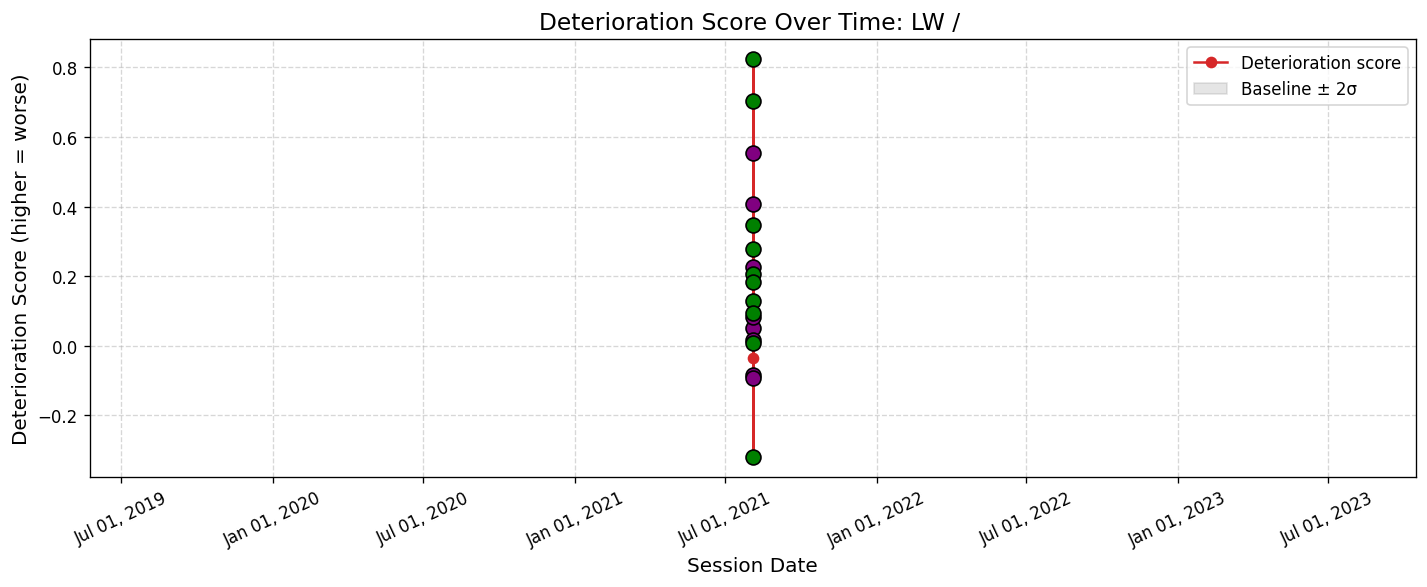

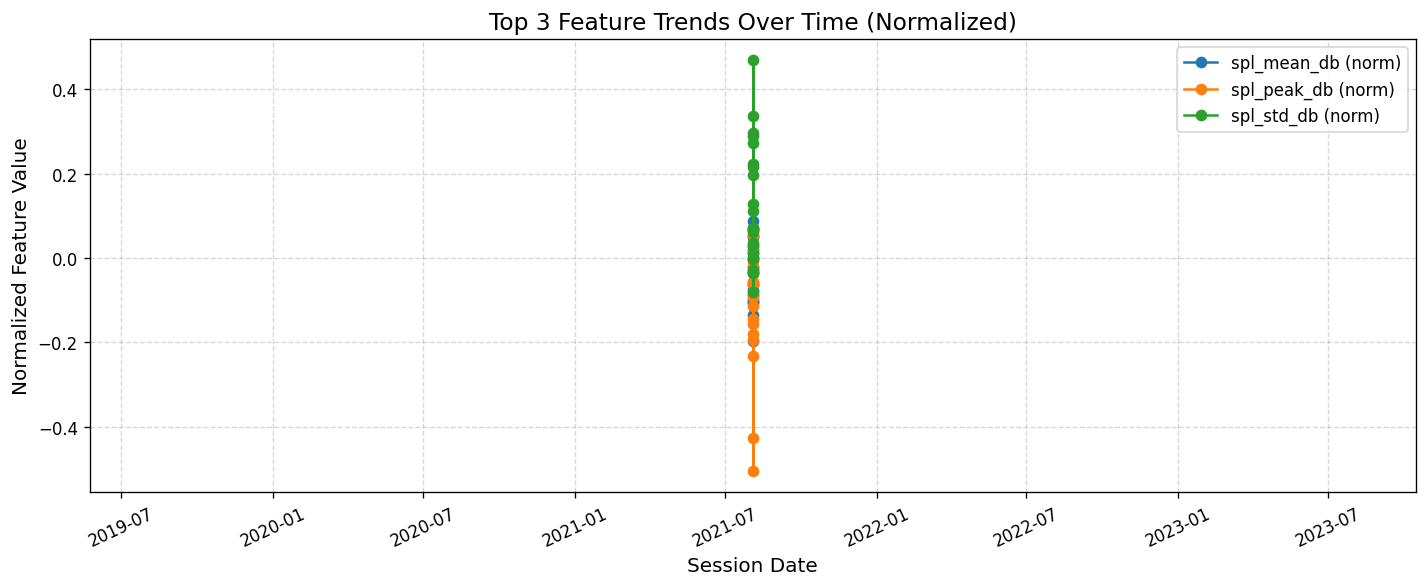

Processing finished: patient analysis plotted and summary printed.



In [22]:
# # Full per-patient pipeline that extracts all features, computes baseline normalization,
# # per-feature slope, a simple deterioration_score and CUSUM detection; then plots deterioration line.

# import matplotlib.dates as mdates
# from datetime import datetime
# from tqdm import tqdm

# def extract_features_for_file(path):
#     """Extract all features for a single WAV file and return dict"""
#     feats = {}
#     y, sr = load_resample(path)
#     y_trim = vad_trim(y, sr)
#     # SPL
#     feats.update(session_spl_stats(y_trim, sr))
#     # Classical
#     feats.update(classical_features(path))
#     # Nonlinear
#     feats.update(nonlinear_features(path))
#     # Wavelet
#     feats.update(wavelet_band_energy(y_trim))
#     # Scattering
#     feats.update(wavelet_scattering_feats(y_trim))
#     # Embeddings stats
#     if TRANSFORMERS_AVAILABLE:
#         try:
#             emb_stats = extract_wav2vec_stats(y_trim, sr)
#             feats.update(emb_stats)
#         except Exception as e:
#             print("Embedding extraction failed for", path, ":", e)
#     # metadata
#     feats["_file"] = path
#     # session date: try parse from text file next to wav (if exists) else file mtime
#     txt_path = os.path.splitext(path)[0] + ".txt"
#     if os.path.exists(txt_path):
#         try:
#             with open(txt_path, 'r', encoding='utf-8') as fh:
#                 txt = fh.read().strip()
#             feats["_transcript"] = txt
#             # Optionally parse date from filename if encoded - here we fallback to mtime
#         except:
#             feats["_transcript"] = ""
#     else:
#         feats["_transcript"] = ""
#     feats["_date"] = datetime.fromtimestamp(os.path.getmtime(path))
#     return feats

# def analyze_patient_fixed(patient_group, patient_subfolder=None):
#     if patient_subfolder:
#         root_dir = os.path.join(BASE_DIR, patient_group, patient_subfolder)
#     else:
#         root_dir = os.path.join(BASE_DIR, patient_group)

#     wavs = sorted(glob.glob(os.path.join(root_dir, "**", "*.wav"), recursive=True))
#     if len(wavs) == 0:
#         print("No wavs found for", root_dir)
#         return None

#     print(f"Found {len(wavs)} WAV files under {root_dir}")
#     rows = [extract_features_for_file(w) for w in wavs]
#     df = pd.DataFrame(rows).reset_index(drop=True)
#     df["session_idx"] = df.index + 1  # numeric session axis

#     # Baseline normalization
#     baseline_N = min(2, len(df))
#     numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#     baseline = df.loc[:baseline_N-1, numeric_cols].mean(skipna=True)

#     # --- Normalize features all at once ---
#     norm_dict = {}
#     slope_map = {}
#     for col in numeric_cols:
#         base = baseline.get(col, np.nan)
#         norm_dict[f"{col}_norm"] = (df[col] - base) / (abs(base) + 1e-9) if not np.isnan(base) else np.nan

#         # Slope over session index
#         if df.shape[0] >= 2:
#             x = df["session_idx"].values.reshape(-1,1)
#             y = df[col].ffill().fillna(0).values.reshape(-1,1)  # fixed FutureWarning
#             lr = LinearRegression().fit(x, y)
#             slope_map[col] = float(lr.coef_[0][0])
#         else:
#             slope_map[col] = 0.0
#     df = pd.concat([df, pd.DataFrame(norm_dict)], axis=1)

#     # Weighted deterioration score
#     weights = {"spl_mean_db": -1.0, "jitter_local": 1.0, "shimmer_local": 1.0, "rpde_approx": 1.0}
#     df["deterioration_score"] = df.apply(lambda row: sum(row.get(f"{feat}_norm",0.0)*w for feat,w in weights.items()), axis=1)

#     # CUSUM
#     def simple_cusum(series, threshold=2.0, drift=0.0):
#         pos = neg = 0.0; alarms = []
#         mu, sigma = np.nanmean(series), np.nanstd(series)+1e-9
#         for x in series:
#             s = (x - mu)/sigma if sigma>0 else 0
#             pos = max(0, pos+s-drift)
#             neg = min(0, neg+s+drift)
#             if pos>threshold: alarms.append("pos_alarm")
#             elif abs(neg)>threshold: alarms.append("neg_alarm")
#             else: alarms.append("ok")
#         return alarms
#     df["cusum_flag"] = simple_cusum(df["deterioration_score"].ffill().fillna(0).values)

#     # --- Plot ---
#     plt.figure(figsize=(10,4))
#     plt.plot(df["session_idx"], df["deterioration_score"], marker='o', label="Deterioration Score")
#     baseline_vals = df.loc[:baseline_N-1, "deterioration_score"]
#     if not baseline_vals.empty:
#         bmean, bstd = baseline_vals.mean(), baseline_vals.std()
#         plt.fill_between(df["session_idx"], bmean-2*bstd, bmean+2*bstd, color='gray', alpha=0.2, label="Baseline ±2σ")
#     plt.title(f"Deterioration over sessions: {patient_group}/{patient_subfolder if patient_subfolder else ''}")
#     plt.xlabel("Session Index")
#     plt.ylabel("Deterioration Score (higher = worse)")
#     plt.grid(True); plt.legend(); plt.show()

#     # --- Summary ---
#     print(f"Patient: {patient_group}/{patient_subfolder if patient_subfolder else ''}")
#     print(f"Sessions analyzed: {len(df)}")
#     print(f"Number of numeric features: {len(numeric_cols)}")
#     top_feats = sorted(slope_map.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
#     print("Top 5 features by absolute slope (trend per session):")
#     for k, v in top_feats:
#         print(f"  {k}: {v:.5f}")
#     print("CUSUM overview:", df["cusum_flag"].value_counts().to_dict())
#     print(f"Baseline sessions used: {baseline_N}")
#     print("Finished: patient analysis plotted and summary printed.\n")
#     return df, slope_map


# # Example usage for patient 'emma' top-level group (analyze entire 'LW' group)
# if "LW" in os.listdir(BASE_DIR):
#     df_LW, slopes_LW = analyze_patient("LW")
# else:
#     print("Patient group 'LW' not found under BASE_DIR.")


Found 20 WAV files under /content/drive/MyDrive/pd_data/denoised-speech-dataset/LW
[SPL] mean=-36.19 dB, peak=-21.14 dB, frames=548
[NonLinear] LW1.wav -> spectral_entropy=2.806, perm_entropy=2.568, recurrence_rate=0.004, rpde=0.363
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=274, mean_mean=-0.0009
[SPL] mean=-37.63 dB, peak=-23.77 dB, frames=302
[NonLinear] LW10.wav -> spectral_entropy=2.432, perm_entropy=2.508, recurrence_rate=0.010, rpde=0.253
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=151, mean_mean=-0.0007
[SPL] mean=-41.15 dB, peak=-23.01 dB, frames=219
[NonLinear] LW11.wav -> spectral_entropy=3.126, perm_entropy=2.544, recurrence_rate=0.002, rpde=0.575
[Wavelet] computed 6 band energies
[Scattering] produced 126 coefficients (mean+std)
[Embeddings] frames=110, mean_mean=-0.0004
[SPL] mean=-41.03 dB, peak=-26.72 dB, frames=257
[NonLinear] LW12.wav -> spectral

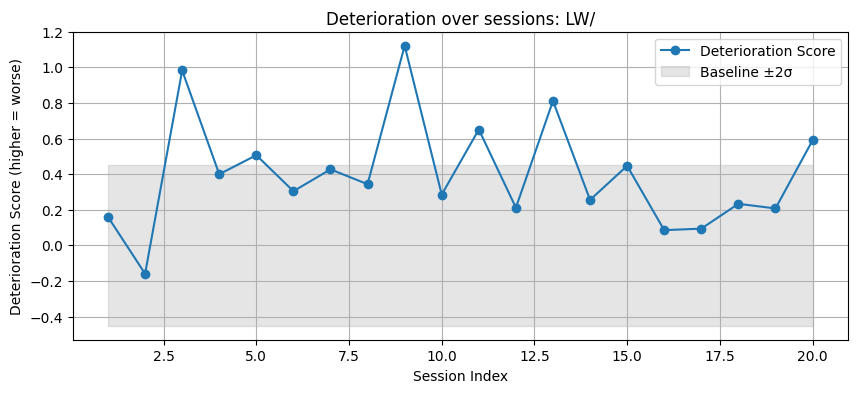

Patient: LW/
Sessions analyzed: 20
Number of numeric features: 278
Top 5 features by absolute slope (trend per session):
  spl_frames: -4.31053
  emb_frames: -2.14887
  session_idx: 1.00000
  wavelet_energy_1: -0.47030
  wavelet_energy_0: -0.42062
CUSUM overview: {'pos_alarm': 13, 'ok': 5, 'neg_alarm': 2}
Baseline sessions used: 2
Finished: patient analysis plotted and summary printed.



In [23]:
# Full per-patient pipeline that extracts all features, computes baseline normalization,
# per-feature slope, a simple deterioration_score and CUSUM detection; then plots deterioration line.

import matplotlib.dates as mdates
from datetime import datetime
from tqdm import tqdm

def extract_features_for_file(path):
    """Extract all features for a single WAV file and return dict"""
    feats = {}
    y, sr = load_resample(path)
    y_trim = vad_trim(y, sr)
    # SPL
    feats.update(session_spl_stats(y_trim, sr))
    # Classical
    feats.update(classical_features(path))
    # Nonlinear
    feats.update(nonlinear_features(path))
    # Wavelet
    feats.update(wavelet_band_energy(y_trim))
    # Scattering
    feats.update(wavelet_scattering_feats(y_trim))
    # Embeddings stats
    if TRANSFORMERS_AVAILABLE:
        try:
            emb_stats = extract_wav2vec_stats(y_trim, sr)
            feats.update(emb_stats)
        except Exception as e:
            print("Embedding extraction failed for", path, ":", e)
    # metadata
    feats["_file"] = path
    # session date: try parse from text file next to wav (if exists) else file mtime
    txt_path = os.path.splitext(path)[0] + ".txt"
    if os.path.exists(txt_path):
        try:
            with open(txt_path, 'r', encoding='utf-8') as fh:
                txt = fh.read().strip()
            feats["_transcript"] = txt
            # Optionally parse date from filename if encoded - here we fallback to mtime
        except:
            feats["_transcript"] = ""
    else:
        feats["_transcript"] = ""
    feats["_date"] = datetime.fromtimestamp(os.path.getmtime(path))
    return feats

def analyze_patient_fixed(patient_group, patient_subfolder=None):
    if patient_subfolder:
        root_dir = os.path.join(BASE_DIR, patient_group, patient_subfolder)
    else:
        root_dir = os.path.join(BASE_DIR, patient_group)

    wavs = sorted(glob.glob(os.path.join(root_dir, "**", "*.wav"), recursive=True))
    if len(wavs) == 0:
        print("No wavs found for", root_dir)
        return None

    print(f"Found {len(wavs)} WAV files under {root_dir}")
    rows = [extract_features_for_file(w) for w in wavs]
    df = pd.DataFrame(rows).reset_index(drop=True)
    df["session_idx"] = df.index + 1  # numeric session axis

    # Baseline normalization
    baseline_N = min(2, len(df))
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    baseline = df.loc[:baseline_N-1, numeric_cols].mean(skipna=True)

    # --- Normalize features all at once ---
    norm_dict = {}
    slope_map = {}
    for col in numeric_cols:
        base = baseline.get(col, np.nan)
        if not np.isnan(base):
            norm_dict[f"{col}_norm"] = (df[col] - base) / (abs(base) + 1e-9)
        else:
            norm_dict[f"{col}_norm"] = np.nan

        # Slope over session index - Fix: use session_idx instead of dates
        if df.shape[0] >= 2:
            x = df["session_idx"].values.reshape(-1,1)
            y = df[col].ffill().fillna(0).values.reshape(-1,1)  # fixed FutureWarning

            # Filter out rows where both x and y are valid
            valid_mask = ~(np.isnan(y.flatten()) | np.isinf(y.flatten()))
            if valid_mask.sum() >= 2:  # Need at least 2 points for regression
                x_valid = x[valid_mask]
                y_valid = y[valid_mask]
                lr = LinearRegression().fit(x_valid, y_valid)
                slope_map[col] = float(lr.coef_[0][0])
            else:
                slope_map[col] = 0.0
        else:
            slope_map[col] = 0.0

    # Use pd.concat to avoid fragmentation warning
    df = pd.concat([df, pd.DataFrame(norm_dict)], axis=1)

    # Weighted deterioration score
    weights = {"spl_mean_db": -1.0, "jitter_local": 1.0, "shimmer_local": 1.0, "rpde_approx": 1.0}
    df["deterioration_score"] = df.apply(lambda row: sum(row.get(f"{feat}_norm",0.0)*w for feat,w in weights.items()), axis=1)

    # CUSUM
    def simple_cusum(series, threshold=2.0, drift=0.0):
        pos = neg = 0.0; alarms = []
        mu, sigma = np.nanmean(series), np.nanstd(series)+1e-9
        for x in series:
            s = (x - mu)/sigma if sigma>0 else 0
            pos = max(0, pos+s-drift)
            neg = min(0, neg+s+drift)
            if pos>threshold: alarms.append("pos_alarm")
            elif abs(neg)>threshold: alarms.append("neg_alarm")
            else: alarms.append("ok")
        return alarms
    df["cusum_flag"] = simple_cusum(df["deterioration_score"].ffill().fillna(0).values)

    # --- Plot ---
    plt.figure(figsize=(10,4))
    plt.plot(df["session_idx"], df["deterioration_score"], marker='o', label="Deterioration Score")
    baseline_vals = df.loc[:baseline_N-1, "deterioration_score"]
    if not baseline_vals.empty:
        bmean, bstd = baseline_vals.mean(), baseline_vals.std()
        plt.fill_between(df["session_idx"], bmean-2*bstd, bmean+2*bstd, color='gray', alpha=0.2, label="Baseline ±2σ")
    plt.title(f"Deterioration over sessions: {patient_group}/{patient_subfolder if patient_subfolder else ''}")
    plt.xlabel("Session Index")
    plt.ylabel("Deterioration Score (higher = worse)")
    plt.grid(True); plt.legend(); plt.show()

    # --- Summary ---
    print(f"Patient: {patient_group}/{patient_subfolder if patient_subfolder else ''}")
    print(f"Sessions analyzed: {len(df)}")
    print(f"Number of numeric features: {len(numeric_cols)}")
    top_feats = sorted(slope_map.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
    print("Top 5 features by absolute slope (trend per session):")
    for k, v in top_feats:
        print(f"  {k}: {v:.5f}")
    print("CUSUM overview:", df["cusum_flag"].value_counts().to_dict())
    print(f"Baseline sessions used: {baseline_N}")
    print("Finished: patient analysis plotted and summary printed.\n")
    return df, slope_map


# Example usage for patient 'emma' top-level group (analyze entire 'LW' group)
if "LW" in os.listdir(BASE_DIR):
    df_LW, slopes_LW = analyze_patient_fixed("LW")
else:
    print("Patient group 'LW' not found under BASE_DIR.")